In [1]:
import os
from collections import defaultdict
from typing import Dict, List, Union

import numpy as np
import matplotlib.pyplot as plt
from utils.parse_logs import parse_configs, parse_metrics

In [10]:
def early_stopping(
    key: str,
    training: Dict[str, List[Union[int, float]]],
    validation: Dict[str, List[Union[int, float]]],
    testing: Dict[str, List[Union[int, float]]],
):

    best_iter = np.argmax(validation[key])
    best_epoch = validation['Epoch'][best_iter]
    yield best_epoch
    for split in (training, validation, testing):
        try:
            split_idx = split['Epoch'].index(best_epoch)
            yield {metric: split[metric][split_idx] if metric is not None else None for metric in split.keys()}
        except ValueError:
            yield None

In [11]:
results = list()
for root, dirs, files in os.walk('./results/', topdown=False):
    for name in files:
        if name == 'logs':
            fn = os.path.join(root, name)
            results.append((parse_configs(fn), parse_metrics(fn)))

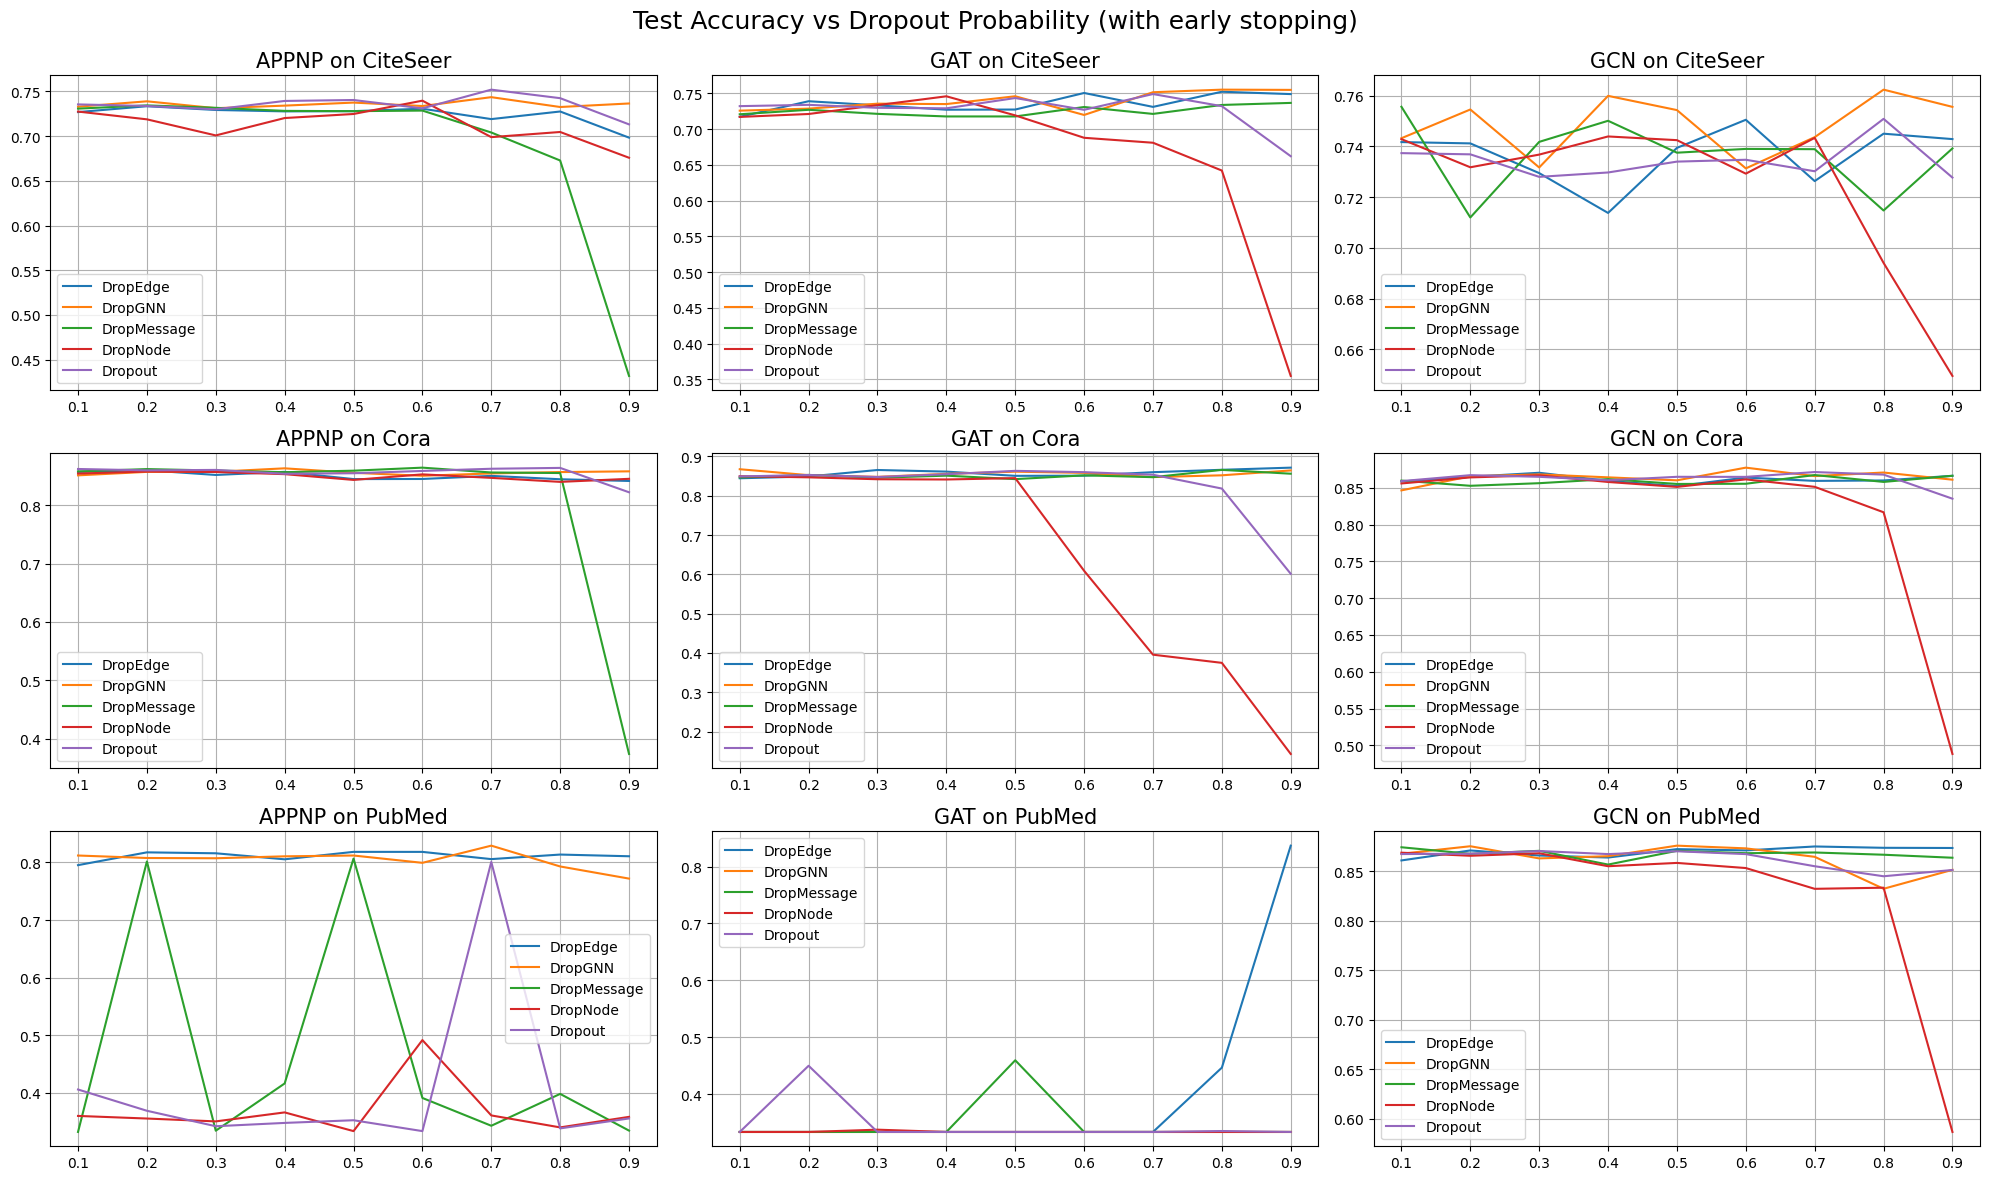

In [8]:
key = 'Accuracy'
datasets = ('Cora', 'CiteSeer', 'PubMed')
models = set()
dropouts = set()

plotting_results = defaultdict(lambda: {'x': [], 'y': []})

for config, (training, validation, testing) in results:
    dataset, model, dropout, drop_p = config['Dataset'], config['GNN'], config['Dropout'], float(config['Dropout probability'])
    if dataset not in datasets:
        continue
    _, _, _, es_test_metrics = early_stopping(key, training, validation, testing)
    es_test_metric = es_test_metrics[key]
    if es_test_metric is None:
        continue
    models.add(model)
    dropouts.add(dropout)
    plotting_results[(dataset, model, dropout)]['x'].append(drop_p)
    plotting_results[(dataset, model, dropout)]['y'].append(es_test_metric)

datasets = sorted(datasets)
models = sorted(models)
dropouts = sorted(dropouts)

# ylims = {
#     'CiteSeer': [0.70, 0.77],
#     'Cora': [0.80, 0.90],
#     'PubMed': [0.78, 0.88],
# }

fig, axs = plt.subplots(len(datasets), len(models), figsize=(20, 12))

for i, dataset in enumerate(datasets):
    for j, model in enumerate(models):
        for dropout in dropouts:
            pr = plotting_results.get((dataset, model, dropout), None)
            if pr is None:
                continue
            axs[i, j].plot(pr['x'], pr['y'], label=dropout)
            axs[i, j].set_title(f'{model} on {dataset}', fontsize=15)
            # axs[i, j].set_ylim(*ylims[dataset])
            axs[i, j].legend()
            axs[i, j].grid()

plt.suptitle(f'Test Accuracy vs Dropout Probability (with early stopping)', fontsize=18)
fig.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

DropGNN seems to outperform others in terms of accuracy (when considering the best dropout probability). <br>
DropNode is bad/unstable. Strange because the results reported were not too bad. <br>
In most cases, the performance of these methods seems to be unaffected by the choice dropout probability.

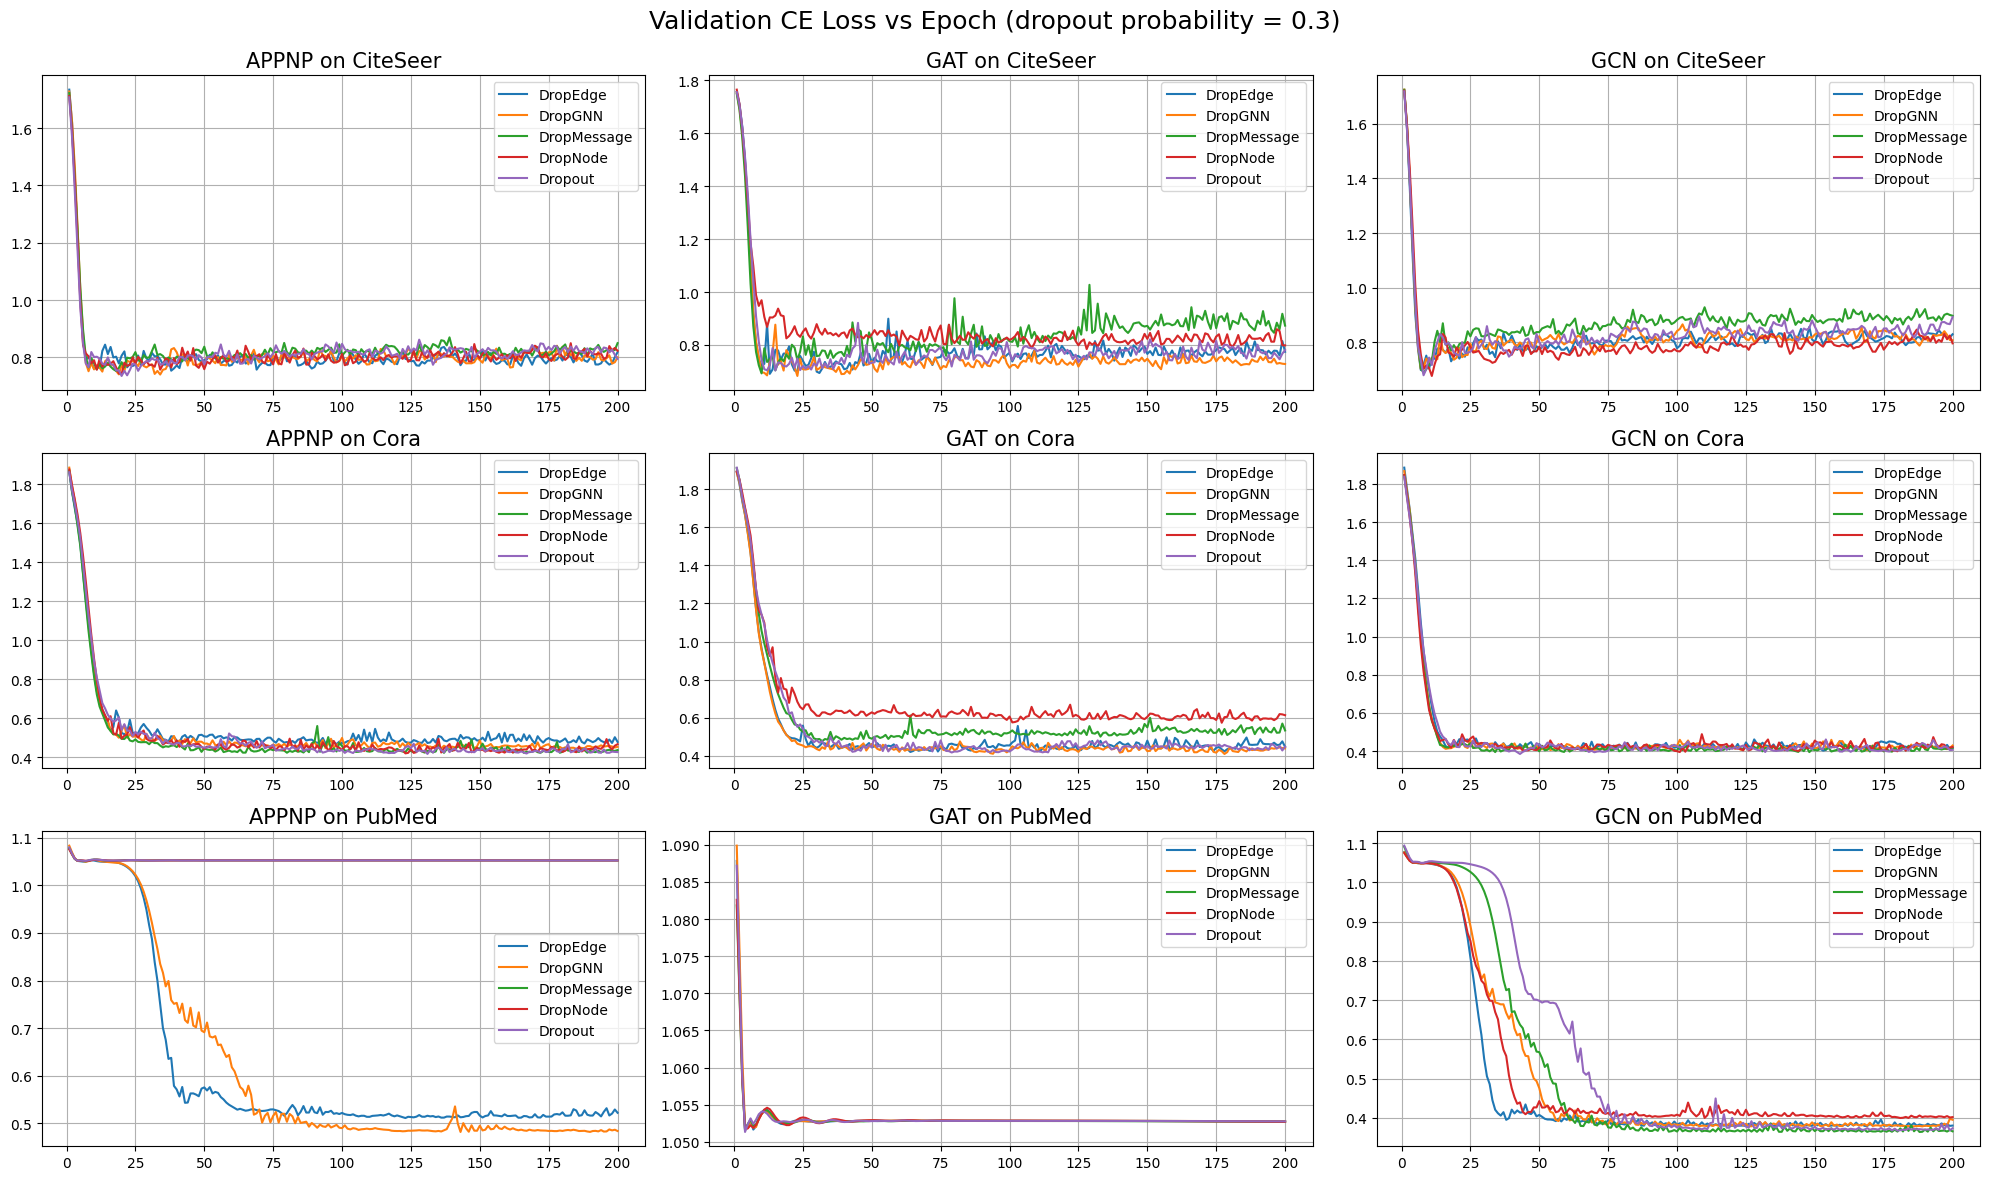

In [5]:
key = 'Cross Entropy Loss'
datasets = ('Cora', 'CiteSeer', 'PubMed')
fixed_drop_p = 0.3

models = set()
dropouts = set()
plotting_results = defaultdict(lambda: defaultdict(str))

for config, (training, validation, testing) in results:
    dataset, model, dropout, drop_p = config['Dataset'], config['GNN'], config['Dropout'], float(config['Dropout probability'])
    if key not in validation or dataset not in datasets or drop_p != fixed_drop_p:
        continue
    models.add(model)
    dropouts.add(dropout)
    plotting_results[(dataset, model, dropout)]['x'] = validation['Epoch']
    plotting_results[(dataset, model, dropout)]['y'] = validation[key]

datasets = sorted(datasets)
models = sorted(models)
dropouts = sorted(dropouts)

fig, axs = plt.subplots(len(datasets), len(models), figsize=(20, 12))

for i, dataset in enumerate(datasets):
    for j, model in enumerate(models):
        for dropout in dropouts:
            pr = plotting_results.get((dataset, model, dropout), None)
            if pr is None:
                continue
            axs[i, j].plot(pr['x'], pr['y'], label=dropout)
        axs[i, j].set_title(f'{model} on {dataset}', fontsize=15)
        axs[i, j].legend()
        axs[i, j].grid()

plt.suptitle(f'Validation CE Loss vs Epoch (dropout probability = {fixed_drop_p})', fontsize=18)
fig.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

Overfitting more significant on CiteSeer than on Cora, which is a smaller dataset.

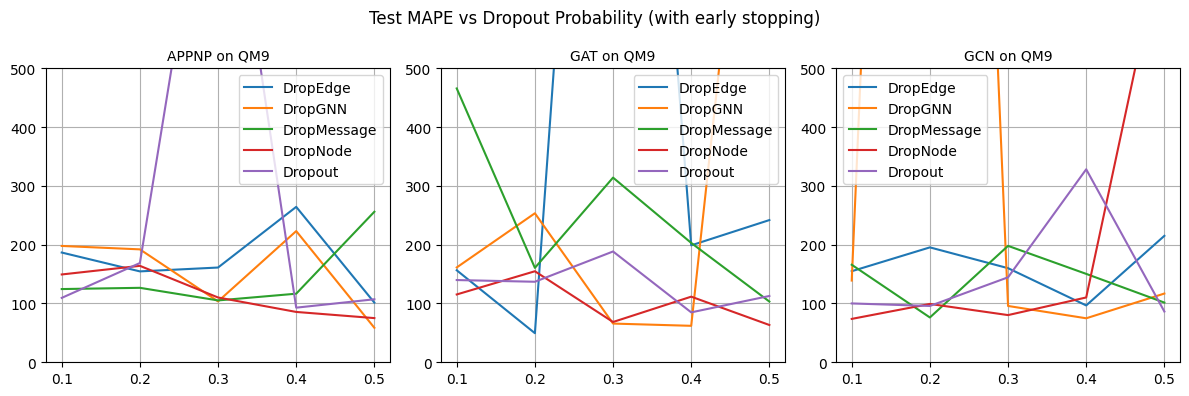

In [13]:
key = 'Mean Absolute Percentage Error'
datasets = ('QM9',)
models = ('GCN', 'GAT', 'APPNP')
dropouts = set()

plotting_results = defaultdict(lambda: {'x': [], 'y': []})

for config, (training, validation, testing) in results:
    dataset, model, dropout, drop_p = config['Dataset'], config['GNN'], config['Dropout'], float(config['Dropout probability'])
    if dataset not in datasets or model not in models:
        continue
    _, _, _, es_test_metrics = early_stopping(key, training, validation, testing)
    es_test_metric = es_test_metrics[key]
    if es_test_metric is None:
        continue
    dropouts.add(dropout)
    plotting_results[(dataset, model, dropout)]['x'].append(drop_p)
    plotting_results[(dataset, model, dropout)]['y'].append(es_test_metric)

datasets = sorted(datasets)
models = sorted(models)
dropouts = sorted(dropouts)

fig, axs = plt.subplots(len(datasets), len(models), figsize=(12, 4))

for i, model in enumerate(models):
    for dropout in dropouts:
        pr = plotting_results.get((dataset, model, dropout), None)
        if pr is None:
            continue
        axs[i].plot(pr['x'], pr['y'], label=dropout)
    axs[i].set_ylim(0, 500)
    axs[i].set_title(f'{model} on {dataset}', fontsize=10)
    axs[i].legend()
    axs[i].grid()

plt.suptitle(f'Test MAPE vs Dropout Probability (with early stopping)', fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()

DropMessage seems to perform a lot better than the other methods. <br>
Almost all dropout methods seem to get worse with higher drop probability. Perhaps, because QM9 is already huge, so overfitting is unlikely...

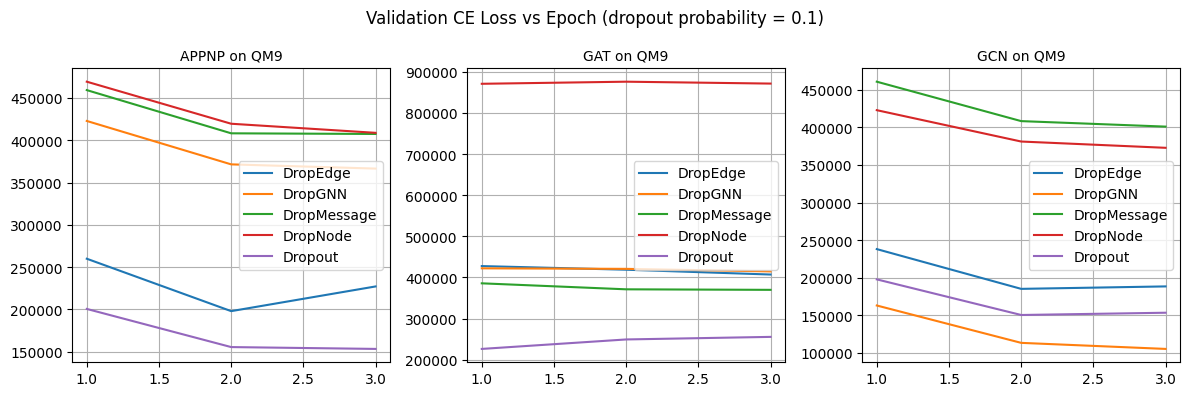

In [15]:
key = 'Mean Squared Error'
datasets = ('QM9',)
fixed_drop_p = 0.1

models = set()
dropouts = set()
plotting_results = defaultdict(lambda: defaultdict(str))

for config, (training, validation, testing) in results:
    dataset, model, dropout, drop_p = config['Dataset'], config['GNN'], config['Dropout'], float(config['Dropout probability'])
    if key not in validation or dataset not in datasets or drop_p != fixed_drop_p:
        continue
    models.add(model)
    dropouts.add(dropout)
    plotting_results[(dataset, model, dropout)]['x'] = validation['Epoch']
    plotting_results[(dataset, model, dropout)]['y'] = validation[key]

datasets = sorted(datasets)
models = sorted(models)
dropouts = sorted(dropouts)

fig, axs = plt.subplots(len(datasets), len(models), figsize=(12, 4))

for i, model in enumerate(models):
    for dropout in dropouts:
        pr = plotting_results.get((dataset, model, dropout), None)
        if pr is None:
            continue
        axs[i].plot(pr['x'], pr['y'], label=dropout)
    axs[i].set_title(f'{model} on {dataset}', fontsize=10)
    axs[i].legend()
    axs[i].grid()

plt.suptitle(f'Validation CE Loss vs Epoch (dropout probability = {fixed_drop_p})', fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()

Can train for more epochs.